In [17]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from typing import Optional
import numpy as np
from fedland.utils import load_all_training_results, get_experiment_description, plot_results_overview

## Experiments 5 Clients, Cifar-10, Resnet

In [4]:
df = load_all_training_results(results_path="../results")
experiment_ids = [
    "9070ebff-43ab-4eeb-9a8a-d64024ee8e04",
    "b458a5f7-193a-46f4-97d5-aac510bb5952",
    "64b57f5d-dbaf-4ffb-b9db-396ca6f73edc",
    "4b3a8ef9-c2ee-4a01-9260-6e4af635dc03",
    "410ad360-b445-4ae8-b224-6f997845a9b1",
    "3f6c270c-ff3d-4c1d-a01c-3359312cd3c4",
    "5f5b1857-84e7-4620-aa9c-77f9ea5e12da",
    "9d0054da-149f-4a8b-aa2c-6583ba8f7484",
]
df = df[df["experiment_id"].isin(experiment_ids)]
df = df.sort_values(by=["experiment_id", "client_index", "timestamp"])
df['iteration'] = df.groupby(['experiment_id', 'client_index']).cumcount() + 1
df = df.reset_index()
df["pct_change_path_norm"] = df["path_norm"].pct_change()
# for _, row in df.loc[0:100].iterrows():
#     print(f"ci:{row['client_index']}, i:{row['iteration']}")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3495 entries, 0 to 3494
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   index                 3495 non-null   int64         
 1   epoch                 3495 non-null   int64         
 2   learning_rate         3495 non-null   float64       
 3   batch_size            3495 non-null   int64         
 4   len_train_indices     3495 non-null   int64         
 5   len_test_indices      3495 non-null   int64         
 6   momentum              3495 non-null   float64       
 7   train_loss            3495 non-null   float64       
 8   train_accuracy        3495 non-null   float64       
 9   test_loss             3495 non-null   float64       
 10  test_accuracy         3495 non-null   float64       
 11  path_norm             3495 non-null   float64       
 12  global_path_norm      3495 non-null   float64       
 13  timestamp         

/tmp/ipykernel_6026/1112684224.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["pct_change_global"] = temp["global_path_norm"].pct_change()


['Resnet CIFAR-10, 5 clients, non-IID, balanced, fedopt', 'Resnet CIFAR-10, 5 clients, non-IID, balanced, fedavg', 'Resnet CIFAR-10, 5 clients, IID, imbalanced, fedopt', 'Resnet CIFAR-10, 5 clients, non-IID, imbalanced, fedavg', 'Resnet CIFAR-10, 5 clients, IID, imbalanced, fedavg', 'Resnet CIFAR-10, 5 clients, IID, balanced, fedavg', 'Resnet CIFAR-10, 5 clients, non-IID, imbalanced, fedopt', 'Resnet CIFAR-10, 5 clients, IID, balanced, fedopt']


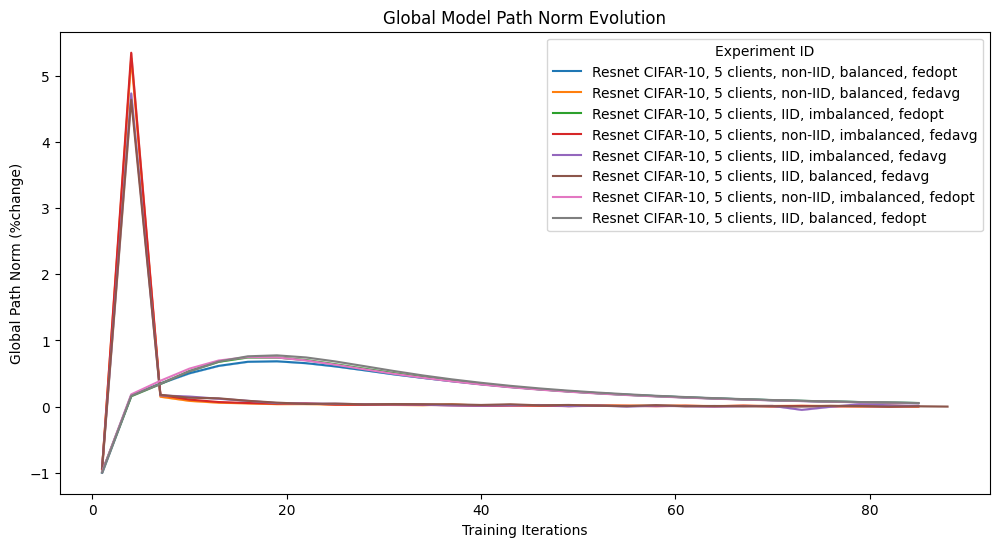

In [15]:
plt.figure(figsize=(12, 6))
temp = df[df["epoch"] == 0]
temp["pct_change_global"] = temp["global_path_norm"].pct_change()
sns.lineplot(data=temp.dropna(), x="iteration", y="pct_change_global", hue="experiment_id")
# sns.lineplot(data=df, x="iteration", y="global_path_norm", hue="experiment_id")
# for epoch_val in df[df['epoch'] == 0]['iteration']:
#     plt.axvline(x=epoch_val, color='gray', linestyle='--', alpha=0.01)
plt.title("Global Model Path Norm Evolution")
plt.xlabel("Training Iterations")
plt.ylabel("Global Path Norm (%change)")
handles, labels = plt.gca().get_legend_handles_labels()
aliased_labels = [get_experiment_description(label, "../results") for label in labels]
print(aliased_labels)
plt.legend(handles=handles, labels=aliased_labels, title="Experiment ID")
plt.show()

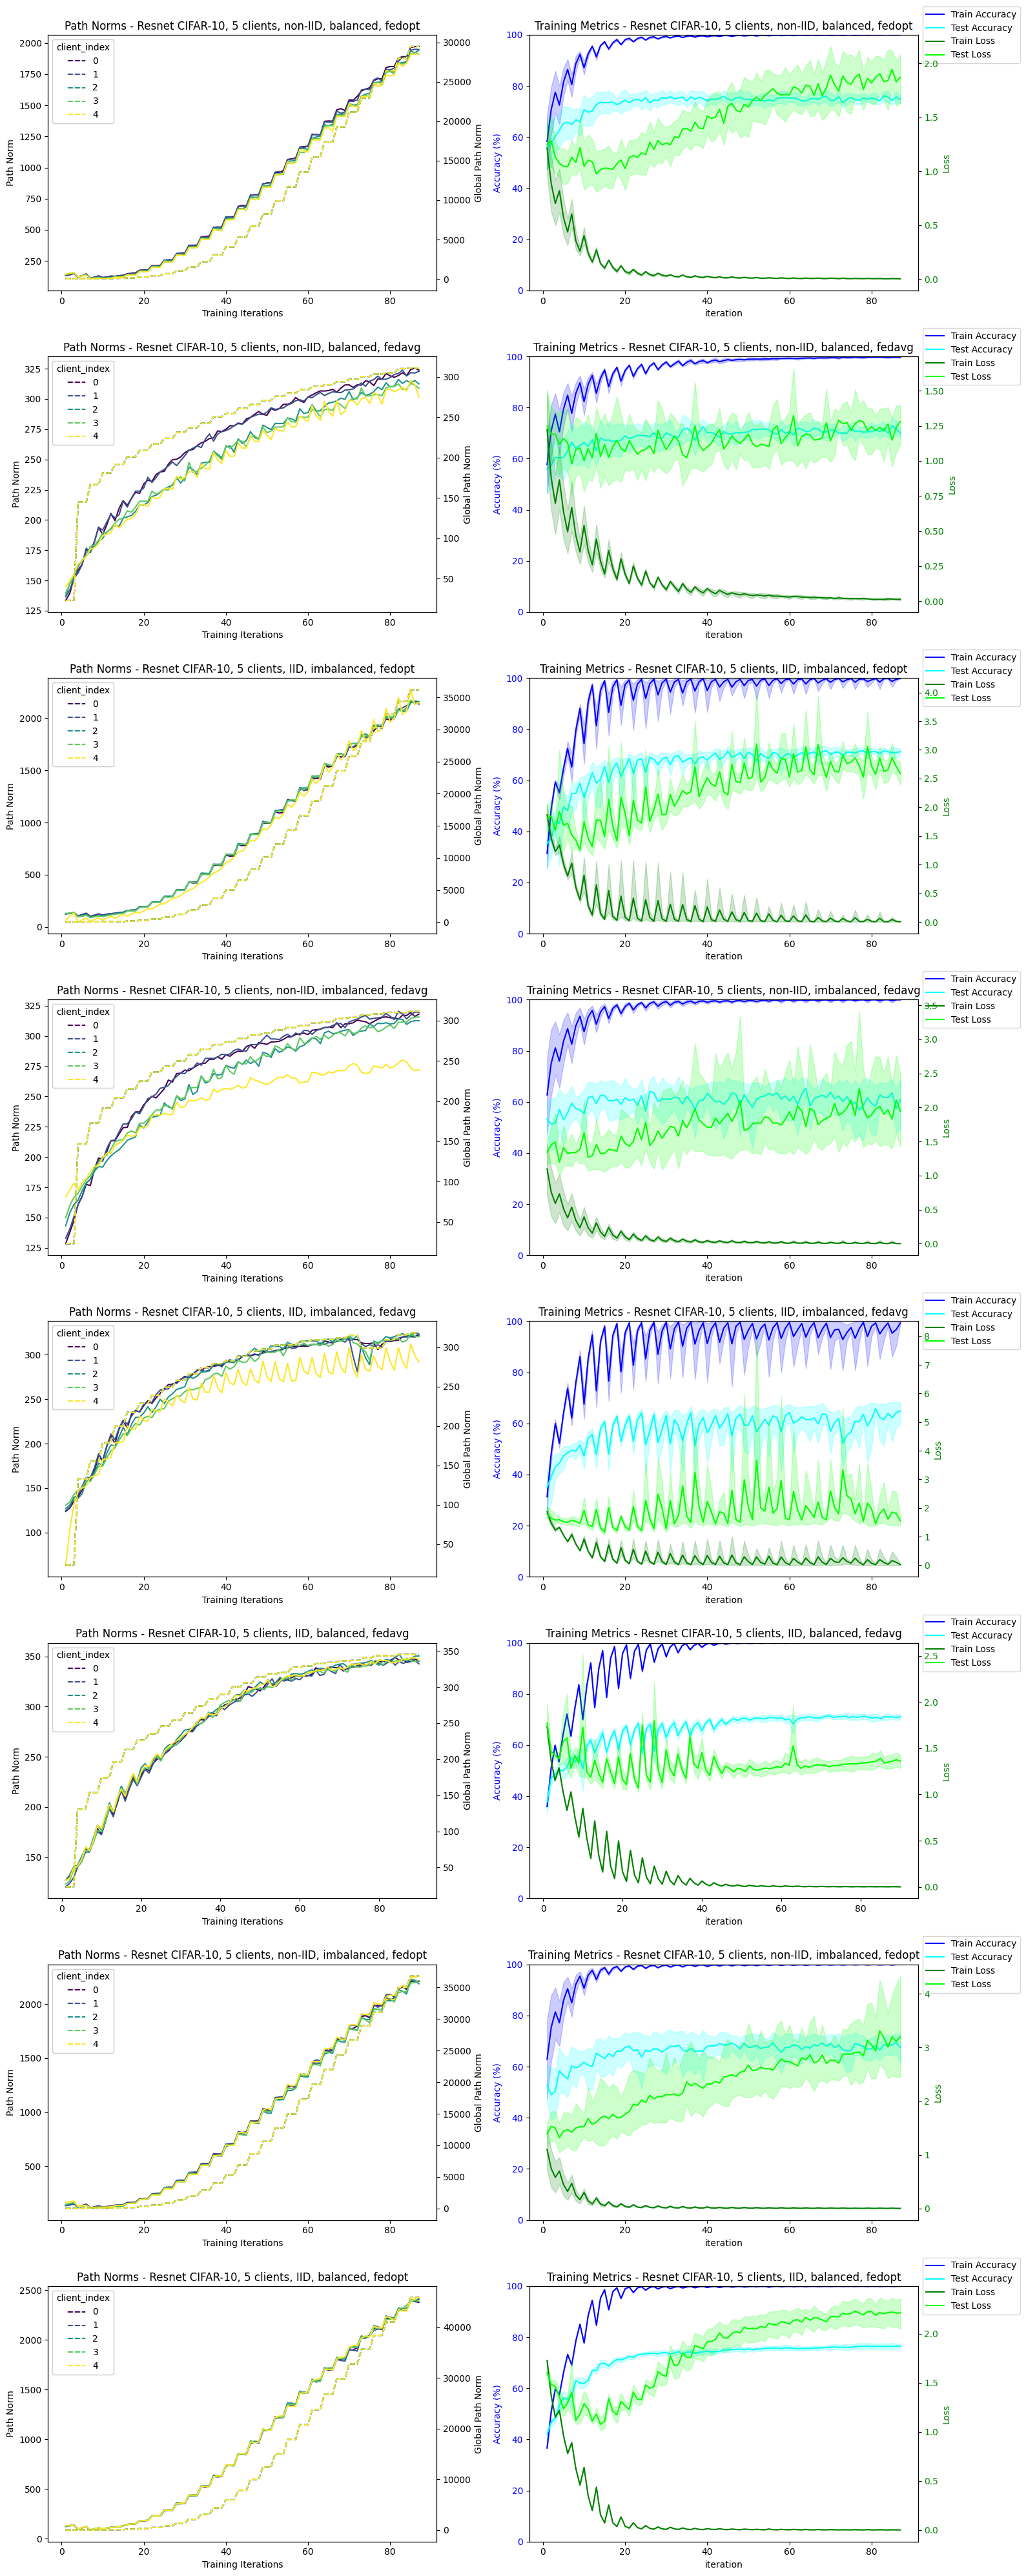

In [4]:
plot_results_overview(df, "../results")

/tmp/ipykernel_6026/4252691092.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exp_data_pre_aggregate["pct_path_norm"] = exp_data_pre_aggregate["path_norm"].pct_change()
/tmp/ipykernel_6026/4252691092.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exp_data_global["pct_global"] = exp_data_global["global_path_norm"].pct_change()
/tmp/ipykernel_6026/4252691092.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = 

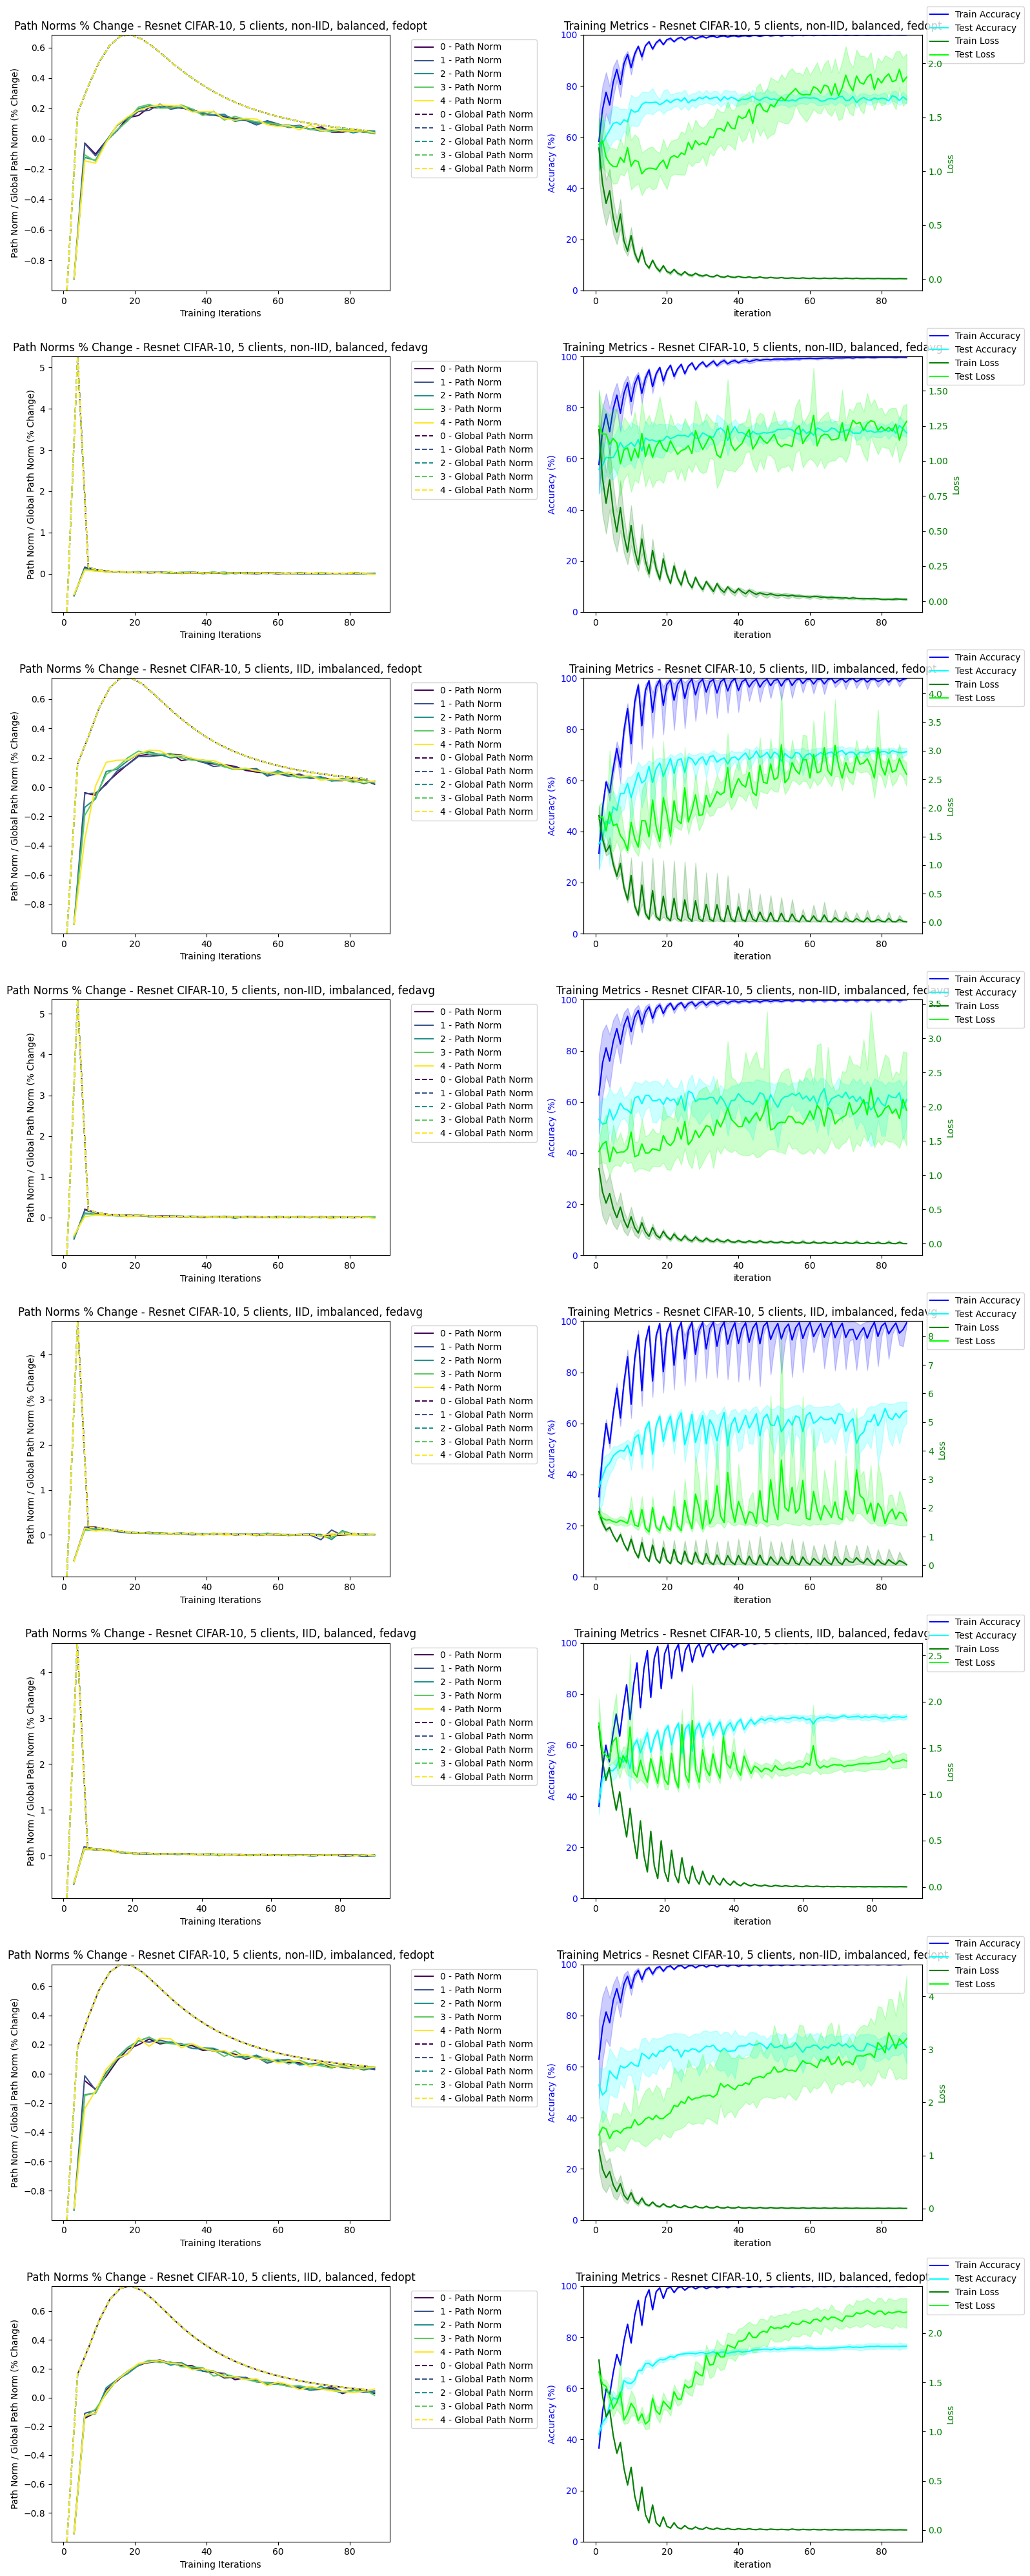

In [24]:
def plot_results_pct(df, results_path: str = "../results", errorbars: Optional = ("ci", 90)):
    """
    Create consistent visualization of federated learning experiments.

    Default 90% CI bands around training stats
    """
    experiment_ids = df["experiment_id"].unique()
    n_experiments = len(experiment_ids)
    fig, axs = plt.subplots(n_experiments, 2, figsize=(16, 5*n_experiments))

    for i, experiment_id in enumerate(experiment_ids):
        exp_data = df[df["experiment_id"] == experiment_id]
        exp_data_pre_aggregate = exp_data[exp_data["epoch"] == max(exp_data["epoch"])]
        exp_data_pre_aggregate["pct_path_norm"] = exp_data_pre_aggregate["path_norm"].pct_change()
        exp_data_global = exp_data[exp_data["epoch"] == 0]
        exp_data_global["pct_global"] = exp_data_global["global_path_norm"].pct_change()
        exp_description = get_experiment_description(experiment_id, results_path)
        
        # First subplot: Path Norms
        ax1 = axs[i, 0]
        
        # Combine path norms to get a consistent y-axis scale
        path_norm_min = min(exp_data_pre_aggregate["pct_path_norm"].min(), exp_data_global["pct_global"].min())
        path_norm_max = max(exp_data_pre_aggregate["pct_path_norm"].max(), exp_data_global["pct_global"].max())
        
        # Path Norm plot
        sns.lineplot(data=exp_data_pre_aggregate.dropna(), x="iteration", y="pct_path_norm",
                     hue="client_index", ax=ax1, palette="viridis")
        
        # Global Path Norm plot on the same axis
        sns.lineplot(data=exp_data_global.dropna(), x="iteration", y="pct_global",
                     hue="client_index", ax=ax1, palette="viridis",
                     linestyle="--")
        
        # Set y-axis limits and labels
        ax1.set_ylim(path_norm_min, path_norm_max)
        ax1.set_title(f"Path Norms % Change - {exp_description}")
        ax1.set_xlabel("Training Iterations")
        ax1.set_ylabel("Path Norm / Global Path Norm (% Change)")

        # Modify legend to distinguish path norm and global path norm
        handles, labels = ax1.get_legend_handles_labels()
        # Split handles and labels into two groups
        half = len(handles) // 2
        first_group_handles = handles[:half]
        first_group_labels = labels[:half]
        second_group_handles = handles[half:]
        second_group_labels = labels[half:]
        
        # Modify labels to indicate path norm vs global path norm
        first_group_labels = [f"{label} - Path Norm" for label in first_group_labels]
        second_group_labels = [f"{label} - Global Path Norm" for label in second_group_labels]
        
        # Combine and create legend
        combined_handles = first_group_handles + second_group_handles
        combined_labels = first_group_labels + second_group_labels
        ax1.legend(combined_handles, combined_labels, bbox_to_anchor=(1.05, 1), loc='upper left')

        # Second subplot: Accuracies and Losses
        ax2 = axs[i, 1]
        ax2_loss = ax2.twinx()
        
        # Accuracy lines
        sns.lineplot(data=exp_data, x="iteration", y="train_accuracy",
                     ax=ax2, color="blue", label="Train Accuracy",
                     errorbar=errorbars)
        sns.lineplot(data=exp_data, x="iteration", y="test_accuracy",
                     ax=ax2, color="cyan", label="Test Accuracy",
                     errorbar=errorbars)
        
        # Loss lines
        sns.lineplot(data=exp_data, x="iteration", y="train_loss",
                     ax=ax2_loss, color="green", label="Train Loss",
                     errorbar=errorbars)
        sns.lineplot(data=exp_data, x="iteration", y="test_loss",
                     ax=ax2_loss, color="lime", label="Test Loss",
                     errorbar=errorbars)
        
        # Set y-axis limits
        ax2.set_ylim(0, 100)
        ax2.set_ylabel("Accuracy (%)", color="blue")
        ax2_loss.set_ylabel("Loss", color="green")
        ax2.tick_params(axis="y", labelcolor="blue")
        ax2_loss.tick_params(axis="y", labelcolor="green")

        ax2.set_title(f"Training Metrics - {exp_description}")
        lines1, labels1 = ax2.get_legend_handles_labels()
        lines2, labels2 = ax2_loss.get_legend_handles_labels()
        all_lines = lines1 + lines2
        all_labels = labels1 + labels2
        ax2.legend(all_lines, all_labels, loc="center left", bbox_to_anchor=(1, 1))
        ax2_loss.get_legend().remove()

    plt.tight_layout()
    plt.show()
plot_results_pct(df)